In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.constants as phy
from tqdm import tqdm
from scipy import linalg

In [3]:
class QuantumTunnel:
    def __init__(self, potential_wall,
                 mass = 1, hbar=1,
                 xmin=0, xmax=100, ninterval=1600):
        # 将坐标离散化
        self.x = np.linspace(xmin, xmax, ninterval)    
        self.hbar = hbar
        self.mass = mass
        # 势能算符
        self.U = np.diag(potential_wall(self.x), 0)
        # 波函数、能量本征值
        self.wave, self.avgE = self.wave_packet(self.x)
        # 二阶微分算符
        self.Lap = self.laplacian(ninterval)        
        # 哈密顿算符
        self.H = - hbar**2 / (2*mass) * self.Lap + self.U
        
        self.history = {}
        
    def laplacian(self, N):
        '''构造二阶微分算子：Laplacian'''
        dx = self.x[1] - self.x[0]
        return (-2 * np.diag(np.ones((N), np.float32), 0)
            + np.diag(np.ones((N-1), np.float32), 1)
            + np.diag(np.ones((N-1), np.float32), -1))/(dx**2)
    
    def rho(self, psi):
        '''从归一化的波函数计算概率密度'''
        return (np.conjugate(psi) * psi).real
    
    def evolve(self, tfinal=30.0, nt=400):
        t = np.linspace(0, tfinal, nt)
        dt = t[1] - t[0]
        Ut = linalg.expm(-1j * self.H * dt / self.hbar)
        
        psi_list = []
        rho_list = []
        
        psi = np.copy(self.wave)
        psi_list.append(psi)
        rho_list.append(self.rho(psi))
        
        for i in range(nt):
            psi = np.dot(Ut, psi)
            psi_list.append(psi)
            rho_list.append(self.rho(psi))
            
        return t, self.x, psi_list, rho_list
    
    
    def reflect_probability(self, rho_):
        N = len(self.x)
        dx = self.x[1] - self.x[0]
        return np.sum(rho_[:N//2]) * dx 

    
    def wave_packet(self, x, kmu=2, ka=20):
        '''kmu: peak momentum——波包中心
           ka: momentum width parameter——影响波包的参数
           return the Fourier transformation of 
                  exp(-ka * (k - kmu)^2) * exp(-6j k^2)
        '''
        L = x[-1] - x[0]
        dk = 2 * np.pi / L
        N = len(x)
        k = np.linspace(0, N*dk, N)
        # 动量空间下的高斯波包——给定波函数的初值是一个动量表象下的高斯波包
        psi_k = np.exp(-ka*(k - kmu)**2) * np.exp(-6j * k**2)
        # 动量表象下的 E*|Psi> ——动量算符作用到波函数，这里波函数是动量表象的，所以没用到Lap
        temp = np.dot(np.diag(k*k, 0)/(2*self.mass), psi_k)
        
        # 矩阵模方得动能期望，np.conjugate取矩阵共轭
        avgE = np.dot(np.conjugate(psi_k), temp) * dk
        # 归一化
        avgE = avgE / self.norm(psi_k, dk)**2
        print('<E>', avgE)
        # 傅里叶变换到坐标空间
        psi = np.fft.ifft(psi_k)
        dx = self.x[1] - self.x[0]
        # 坐标表象下的波函数
        psi = psi / self.norm(psi, dx)
        return psi, avgE

    def norm(self, psi, mesh_size):
        # 归一离散化的波函数
        norm = np.sqrt(np.dot(np.conjugate(psi), psi) * mesh_size)
        return norm

    def plot_wave_packet(self, show_density=True):
        '''画初始波包的'''
        with plt.style.context(['science', 'ieee', "no-latex"]):
            plt.plot(self.x, self.wave.real, label=r'$\psi(x)$')
            if show_density: 
                density = (np.conjugate(self.wave) * self.wave).real
                plt.plot(self.x, density, label='$\psi^*(x)\psi(x)$')
            plt.xlabel(r'$x$')
            plt.legend(loc='best', title="wave packet")

    def plot_potential(self):
        with plt.style.context(['science', 'ieee', "no-latex"]):
            plt.plot(self.x, np.diag(self.U))
            plt.ylabel(r'potential')
            plt.xlabel(r'$x$')

Text(0.5, 0, '$x$')

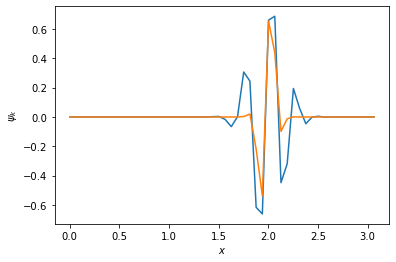

In [26]:
'''
这里跟程序无关，只是试了以下高斯波包
'''
x = np.linspace(0, 100,1600)
L = x[-1] - x[0]
dk = 2 * np.pi / L
N = len(x)
k = np.linspace(0, N*dk, N)
kmu=2
ka=20
# 动量空间下的高斯波包
psi_k = np.exp(-ka*(k - kmu)**2) * np.exp(-6j * k**2)

plt.plot(x[:50], np.real(psi_k[:50]))
# plt.plot(x[:50], np.real(psi_k[:50])**2)
plt.ylabel(r'$psi_k$')
plt.xlabel(r'$x$')

ka=100
# 动量空间下的高斯波包
psi_k = np.exp(-ka*(k - kmu)**2) * np.exp(-6j * k**2)

plt.plot(x[:50], np.real(psi_k[:50]))
# plt.plot(x[:50], np.real(psi_k[:50])**2)
plt.ylabel(r'$\psi_k$')
plt.xlabel(r'$x$')

### 势函数

In [1]:
# 三种势垒的定义
def barrier(x, avgE=2.06, shape="square"):
    '''shape: {square, heavyside, well}'''
    L = x[-1] - x[0]
    if shape == 'square':
        pot = (np.heaviside(x - 0.45 * L, 0.5)-np.heaviside(x - 0.55 * L, 0.5)) * avgE
    elif shape == 'heavyside':
        pot = np.heaviside(x - 0.5 * L, 0.5) * avgE
    elif shape == 'well':
        pot = (np.heaviside(x - 0.55 * L, 0.5)-np.heaviside(x - 0.45 * L, 0.5)) * avgE
    return pot

<E> (2.0062499999999996+0j)


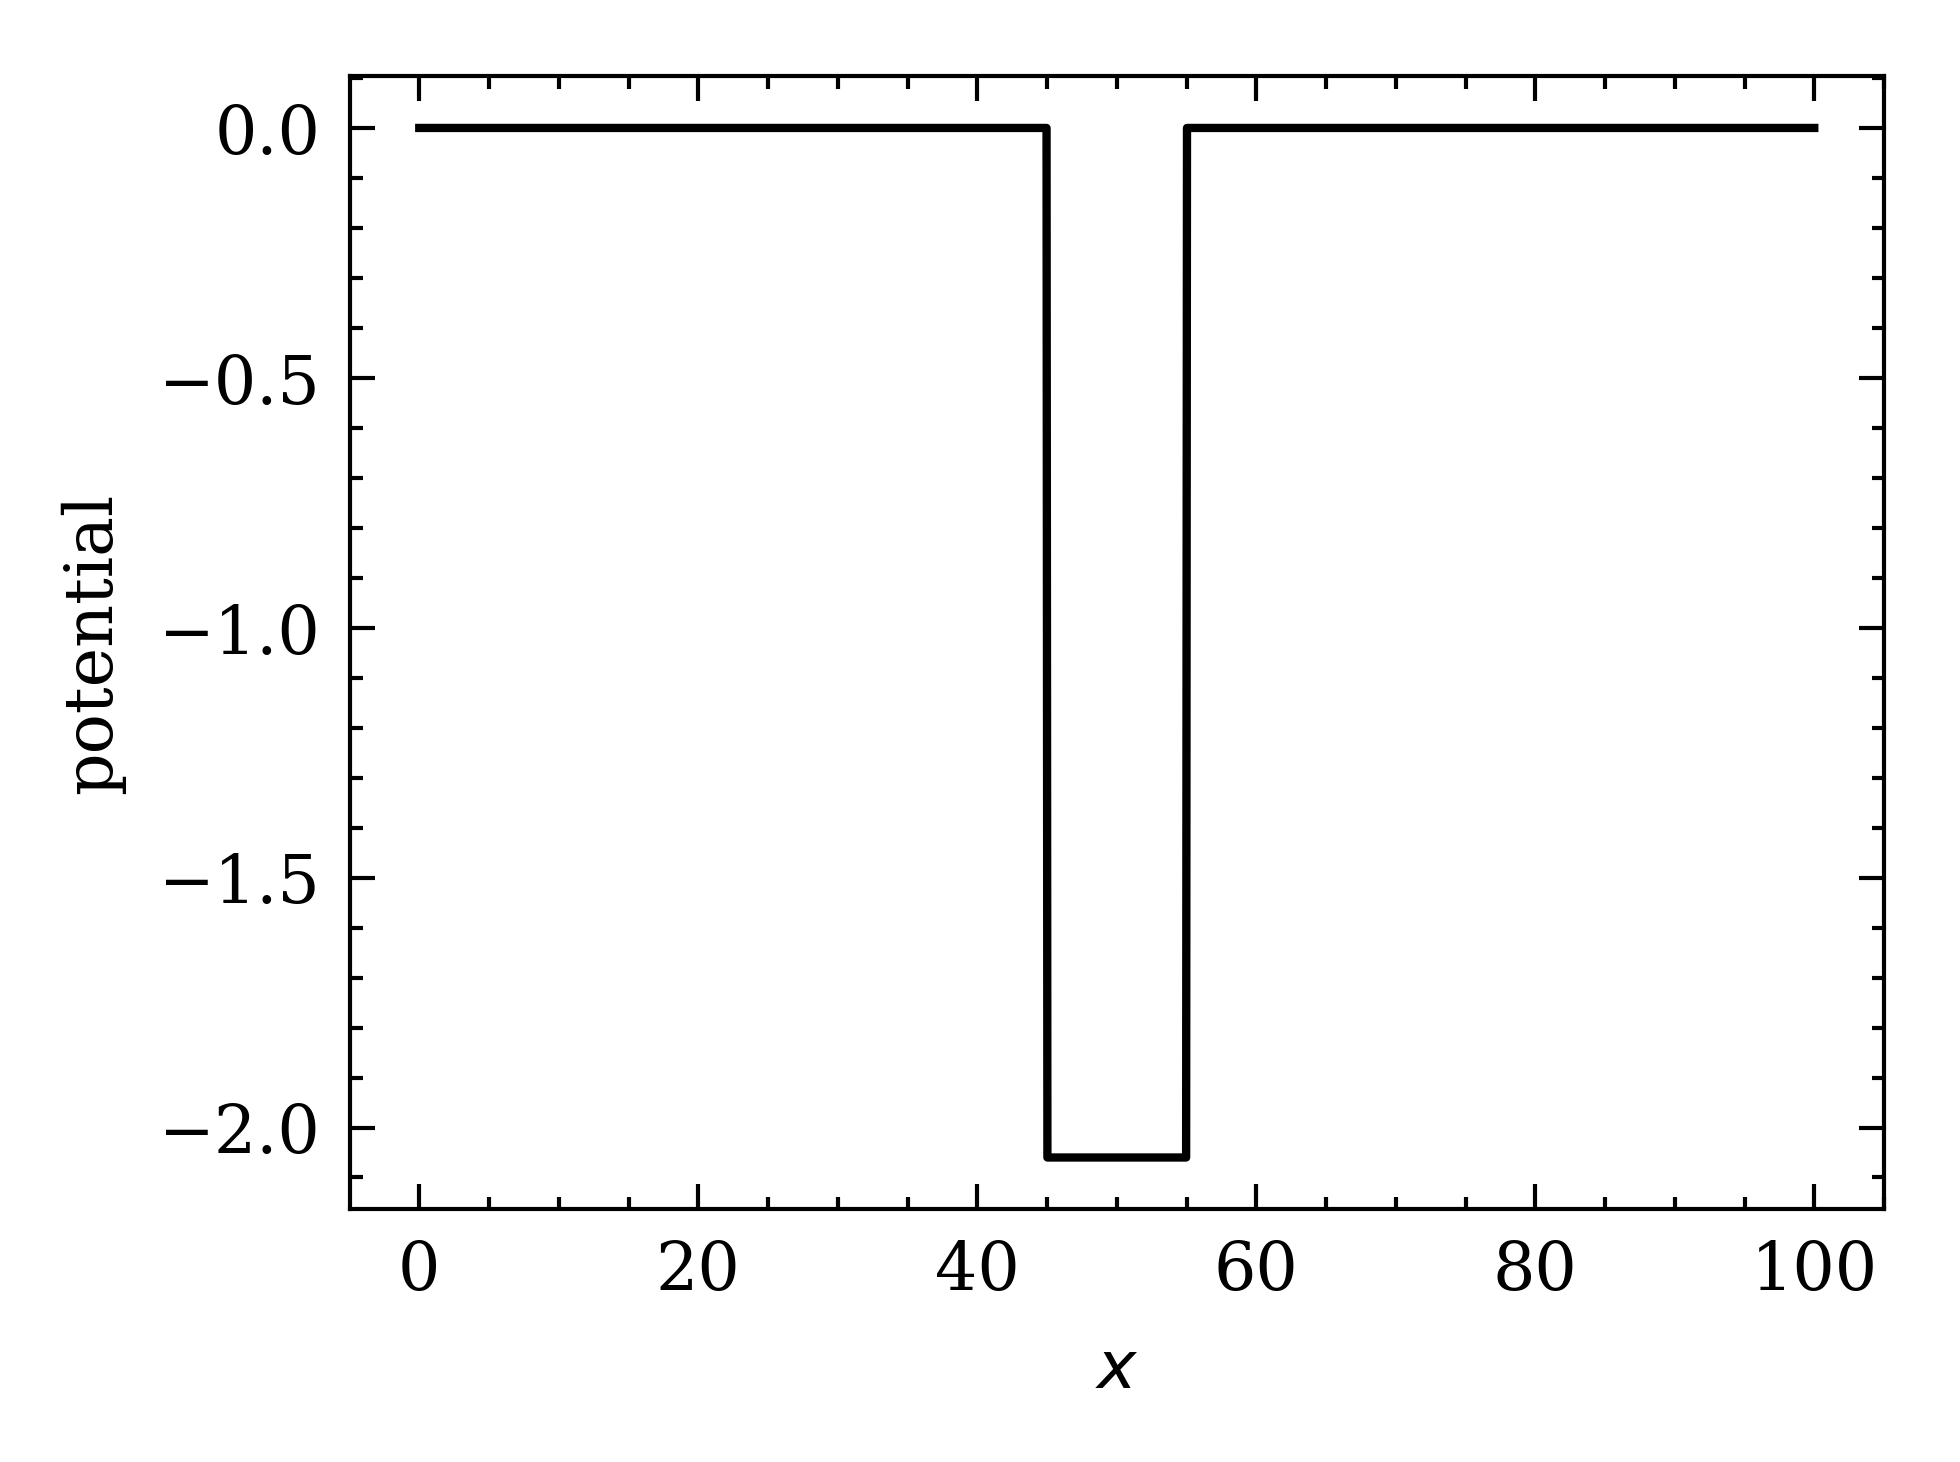

In [6]:
%matplotlib inline
pot = lambda x: barrier(x, shape='well')

# 注意 QuantumTunnel 类在文章的最后提供

qt = QuantumTunnel(potential_wall = pot)

qt.plot_potential()

### 阶梯势垒

<E> (2.0062499999999996+0j)


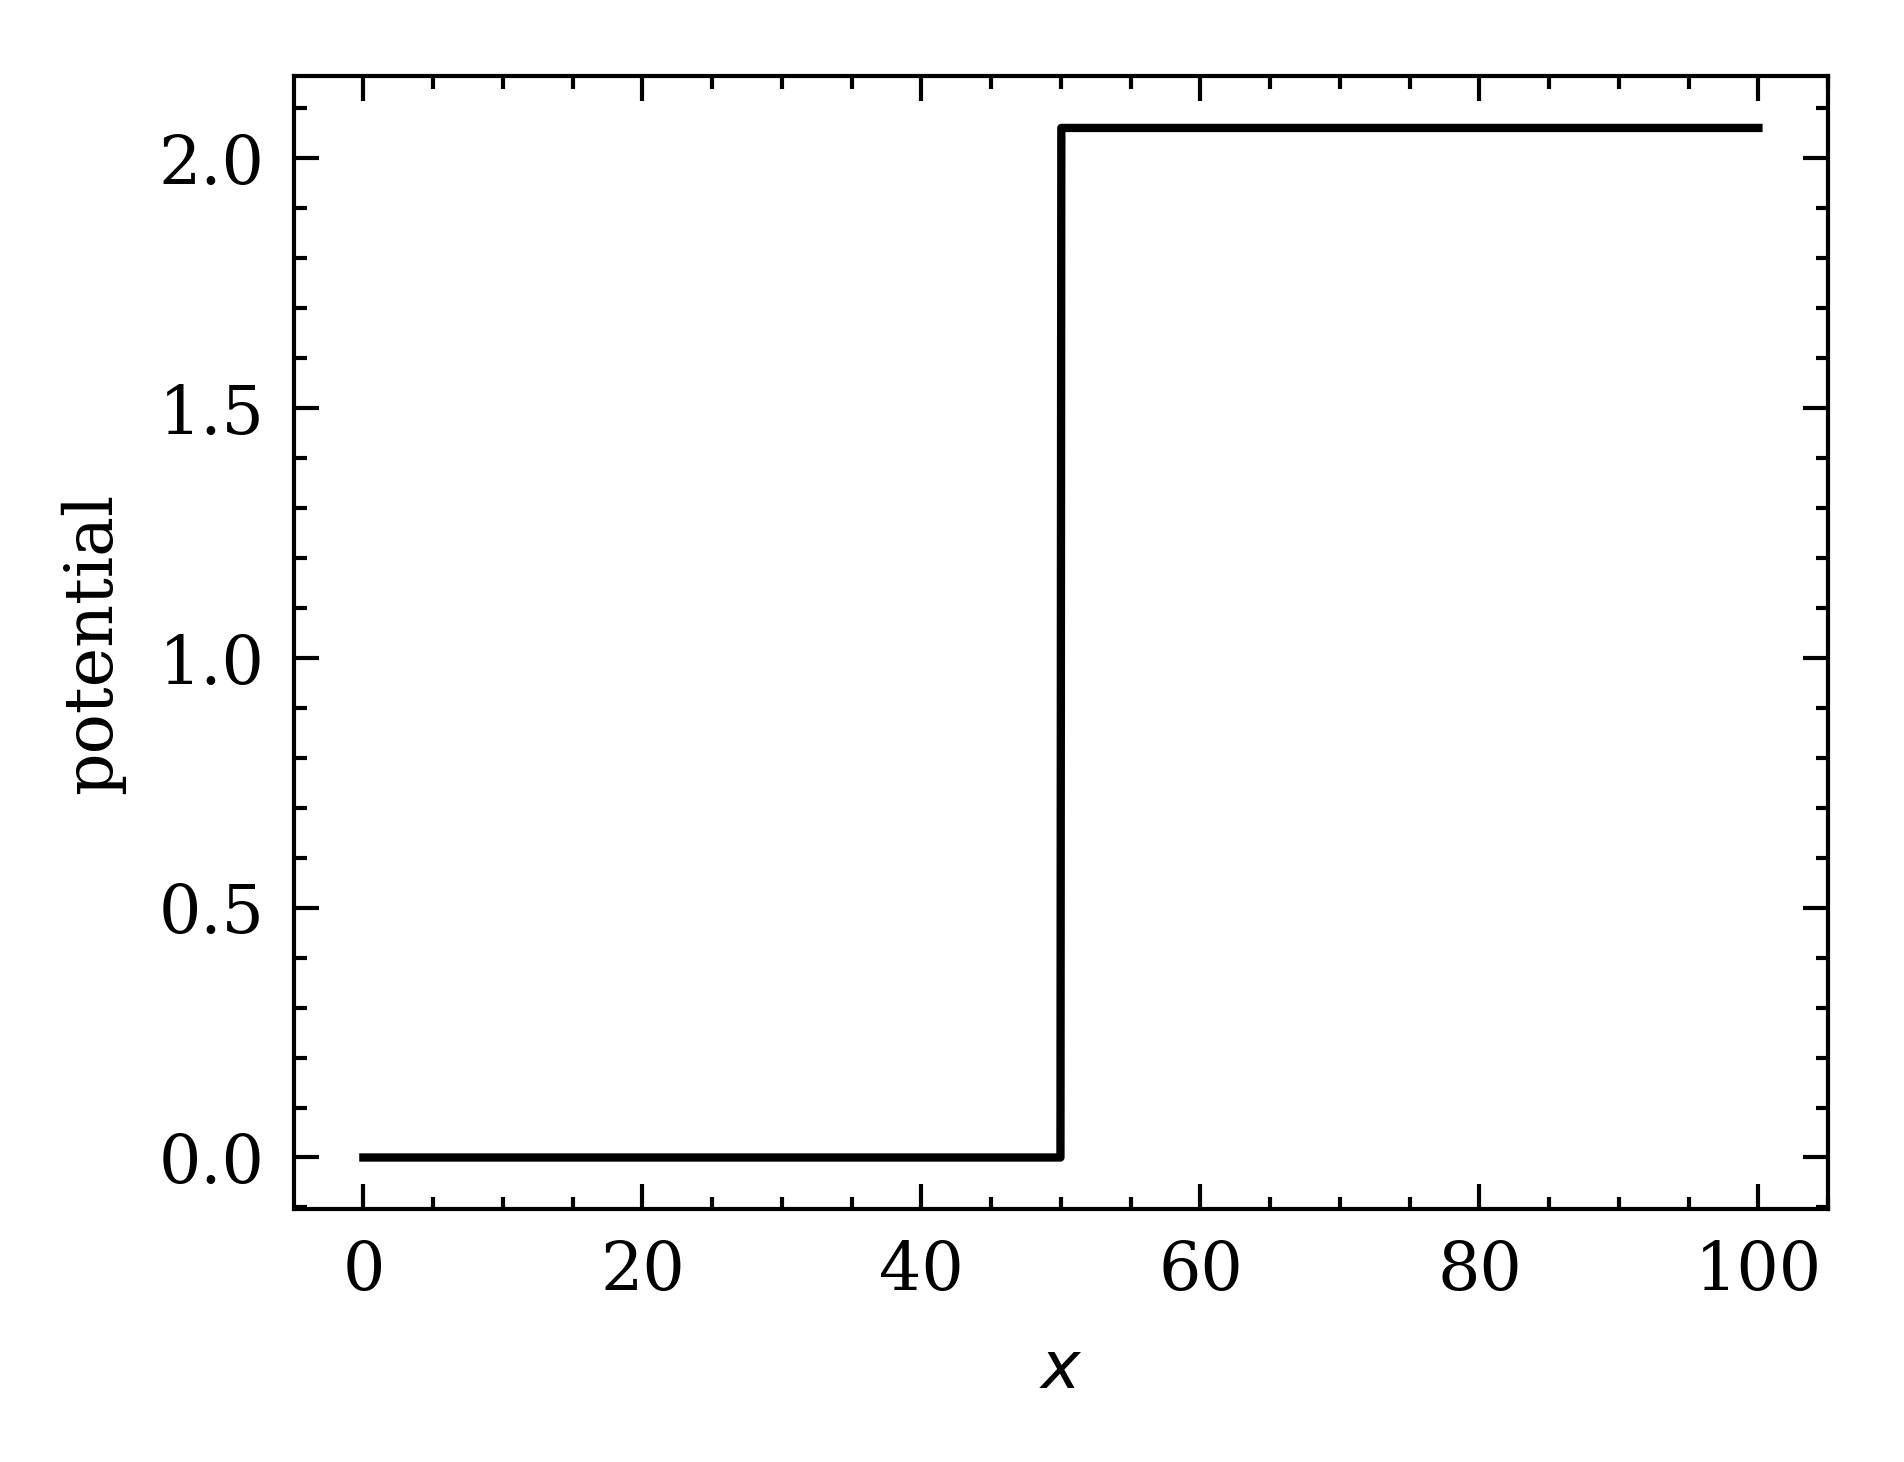

In [232]:
%matplotlib inline
pot = lambda x: barrier(x, shape='heavyside')

# 注意 QuantumTunnel 类在文章的最后提供

qt = QuantumTunnel(potential_wall = pot)

qt.plot_potential()

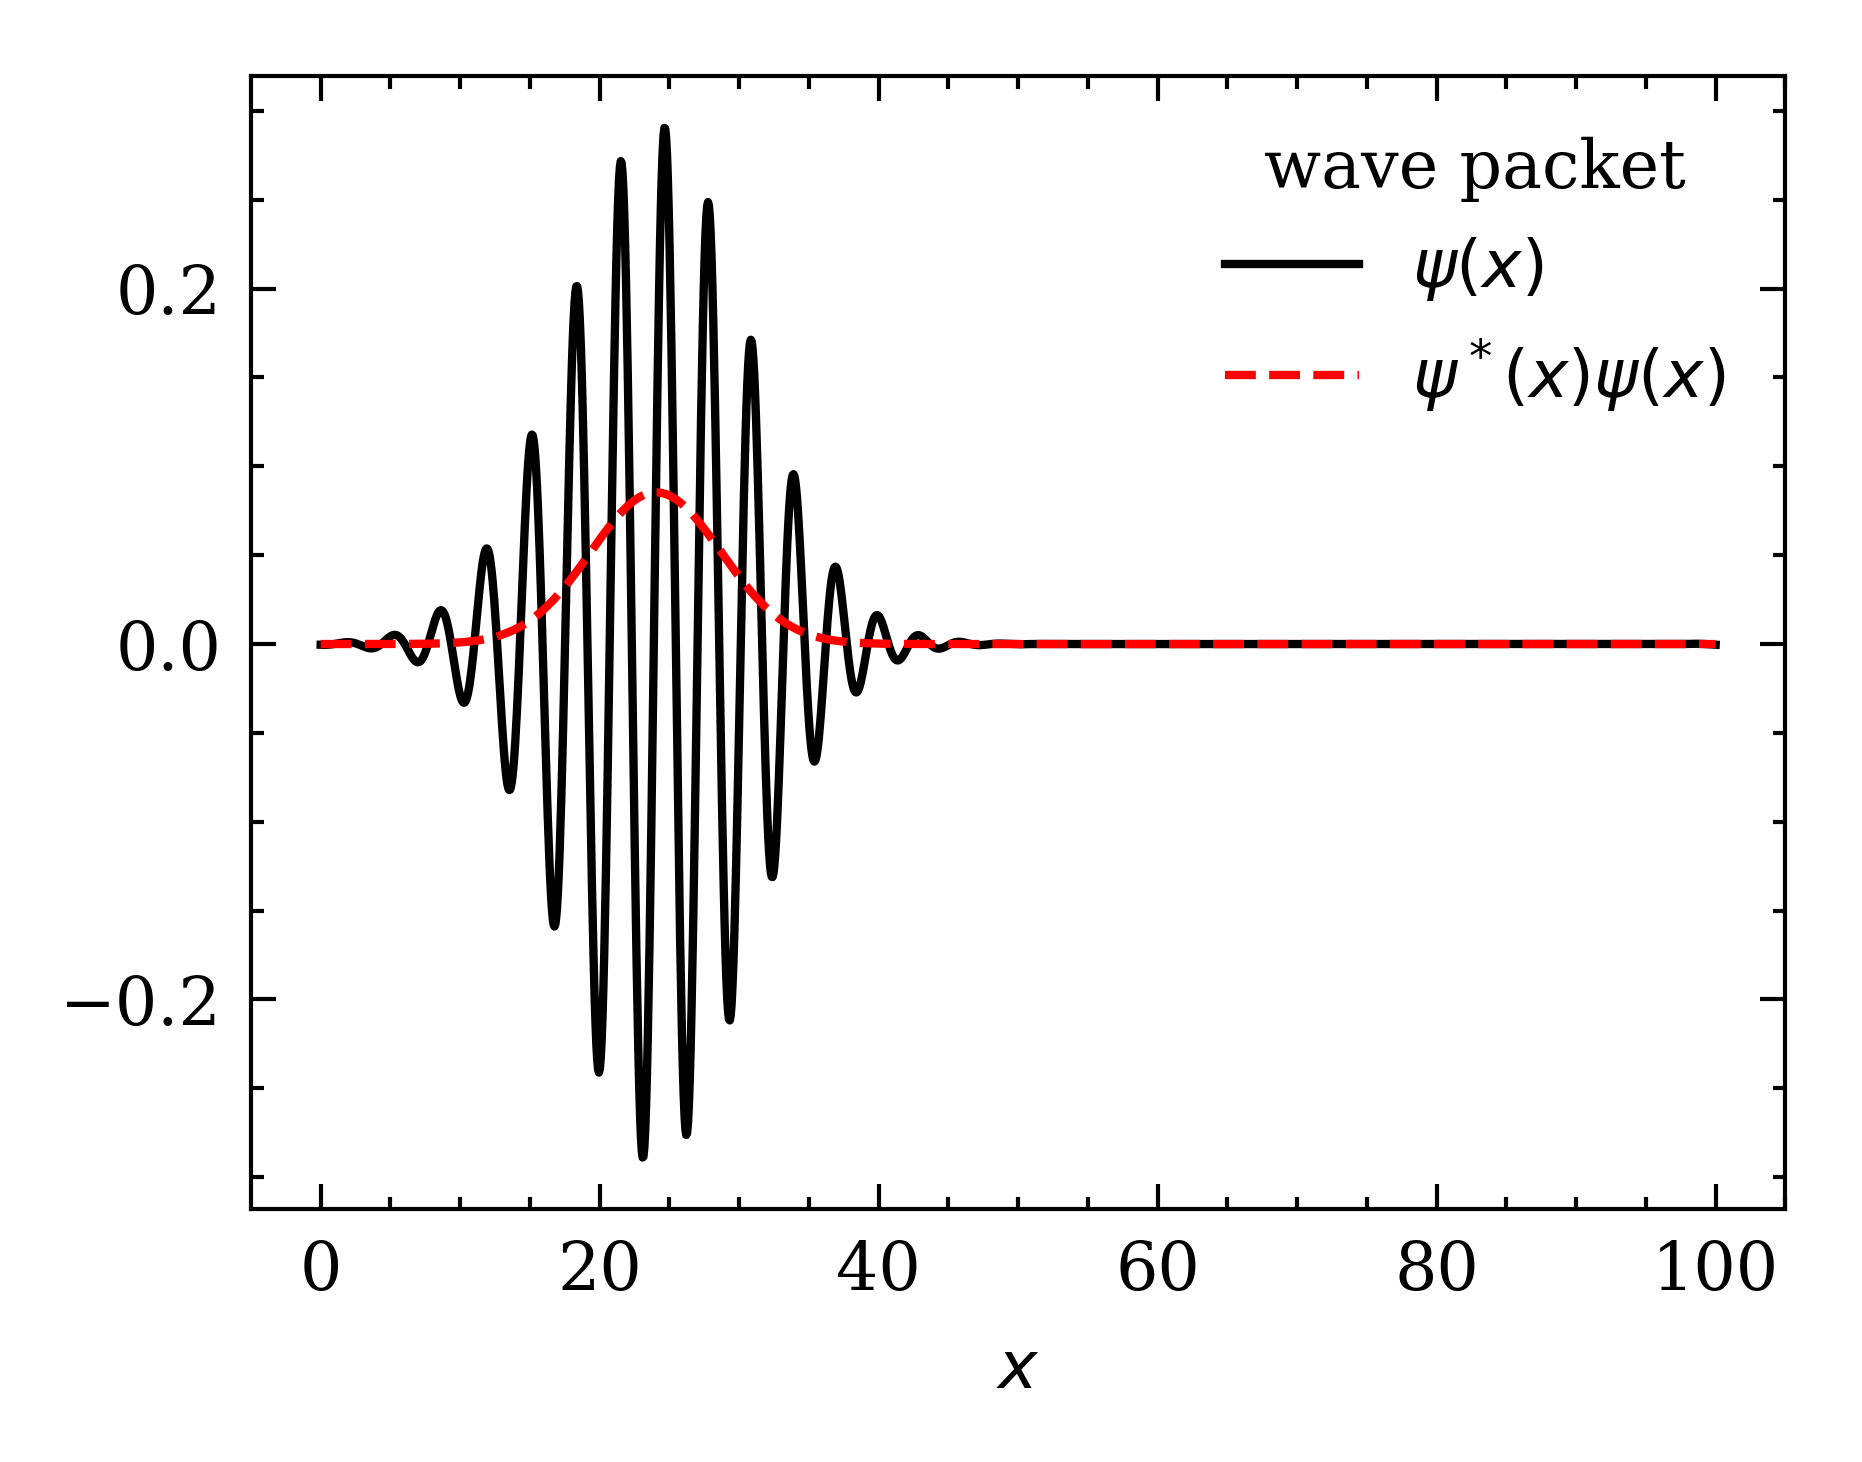

In [142]:
# 初始波包
qt.plot_wave_packet()

In [233]:
# 波包传递
t, x, psi_list, rho_list = qt.evolve(nt=20)

<IPython.core.display.Javascript object>


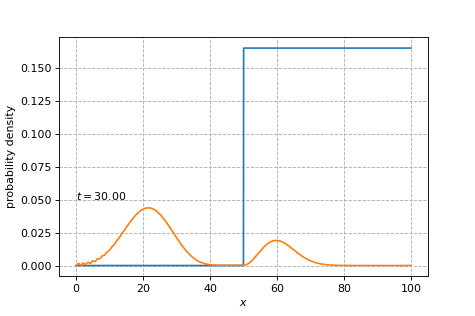

In [237]:
# 绘制
%matplotlib notebook
from matplotlib.animation import FuncAnimation

def update(i):
    line.set_data(qt.x, rho_list[i])
    text.set_text(r'$t=%.2f$'%t[i])
    return line, text,
    

potential = pot(qt.x)

fig1, ax1 = plt.subplots()
plt.plot(qt.x, potential * 0.08)
line, = plt.plot(qt.x, rho_list[0])
text = plt.text(0, 0.05, '')
plt.grid(ls="--")

plt.ylabel('probability density')

plt.xlabel(r'$x$')
anim1 = FuncAnimation(fig1, update, frames=400, interval=100, blit=True)
#anim1.save('../htmls/images/quantum_tuneling.mp4')
plt.show()

### 方势垒

<E> (2.0062499999999996+0j)


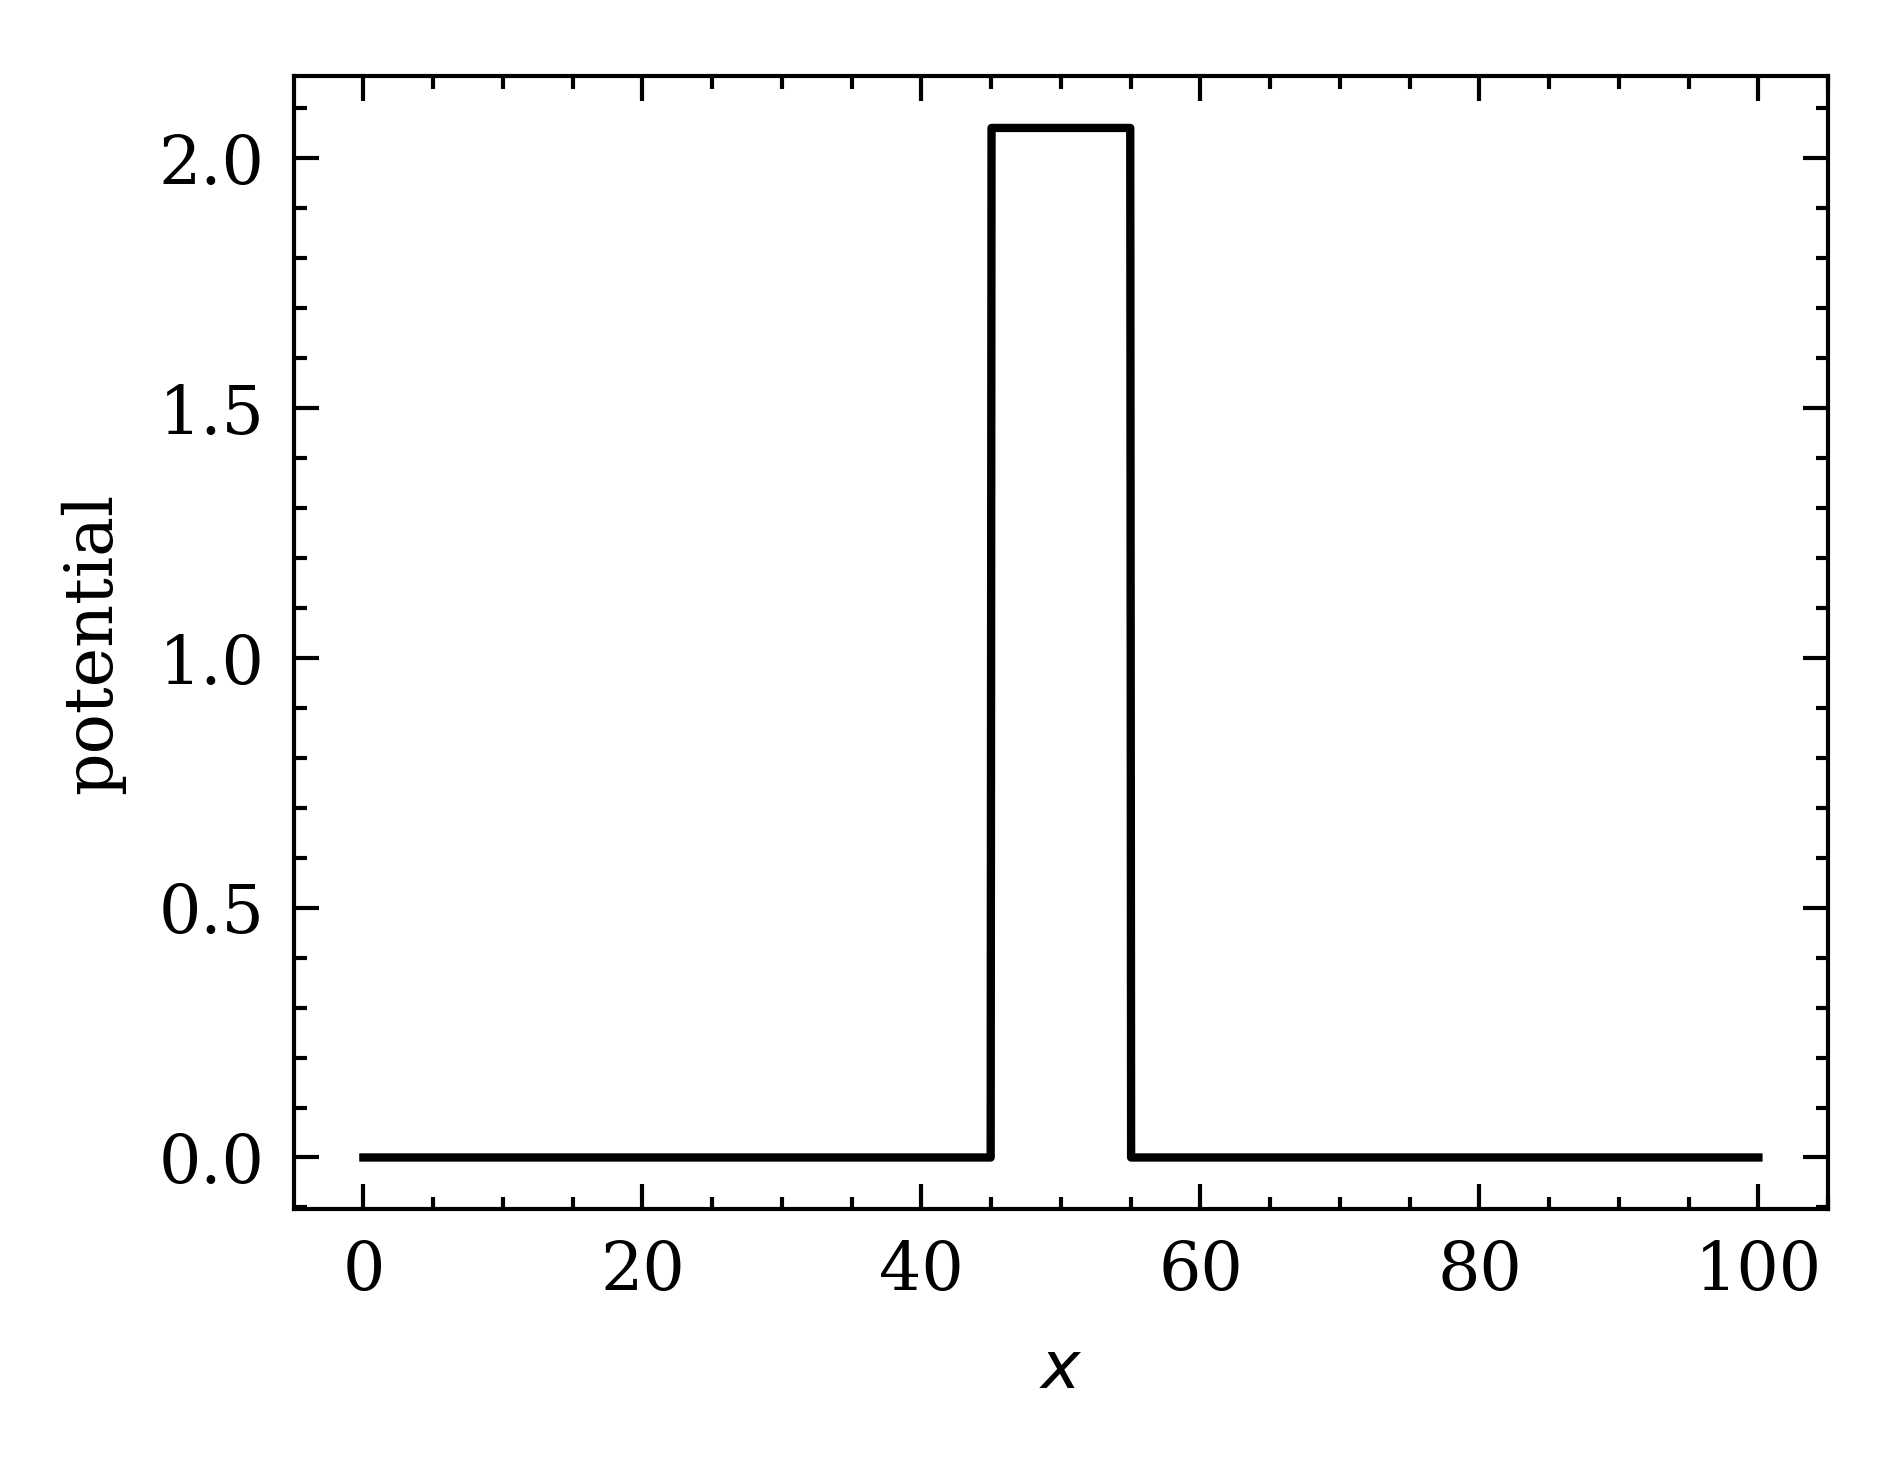

In [7]:
%matplotlib inline
pot = lambda x: barrier(x, shape='square')

qt = QuantumTunnel(potential_wall = pot)

qt.plot_potential()

<IPython.core.display.Javascript object>


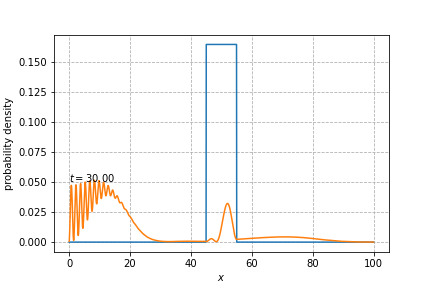

In [9]:
# 波包传递
t, x, psi_list, rho_list = qt.evolve(nt=300)
# 绘制
%matplotlib notebook
from matplotlib.animation import FuncAnimation

def update(i):
    line.set_data(qt.x, rho_list[i])
    text.set_text(r'$t=%.2f$'%t[i])
    return line, text,
    

potential = pot(qt.x)

fig1, ax1 = plt.subplots()
plt.plot(qt.x, potential * 0.08)
line, = plt.plot(qt.x, rho_list[0])
text = plt.text(0, 0.05, '')
plt.grid(ls="--")

plt.ylabel('probability density')

plt.xlabel(r'$x$')
anim1 = FuncAnimation(fig1, update, frames=400, interval=100, blit=True)
#anim1.save('../htmls/images/quantum_tuneling.mp4')
plt.show()

### 改变阶梯状势垒的高度 U0 看反射概率
数值计算中，反射概率等于势垒左边的概率密度累加。

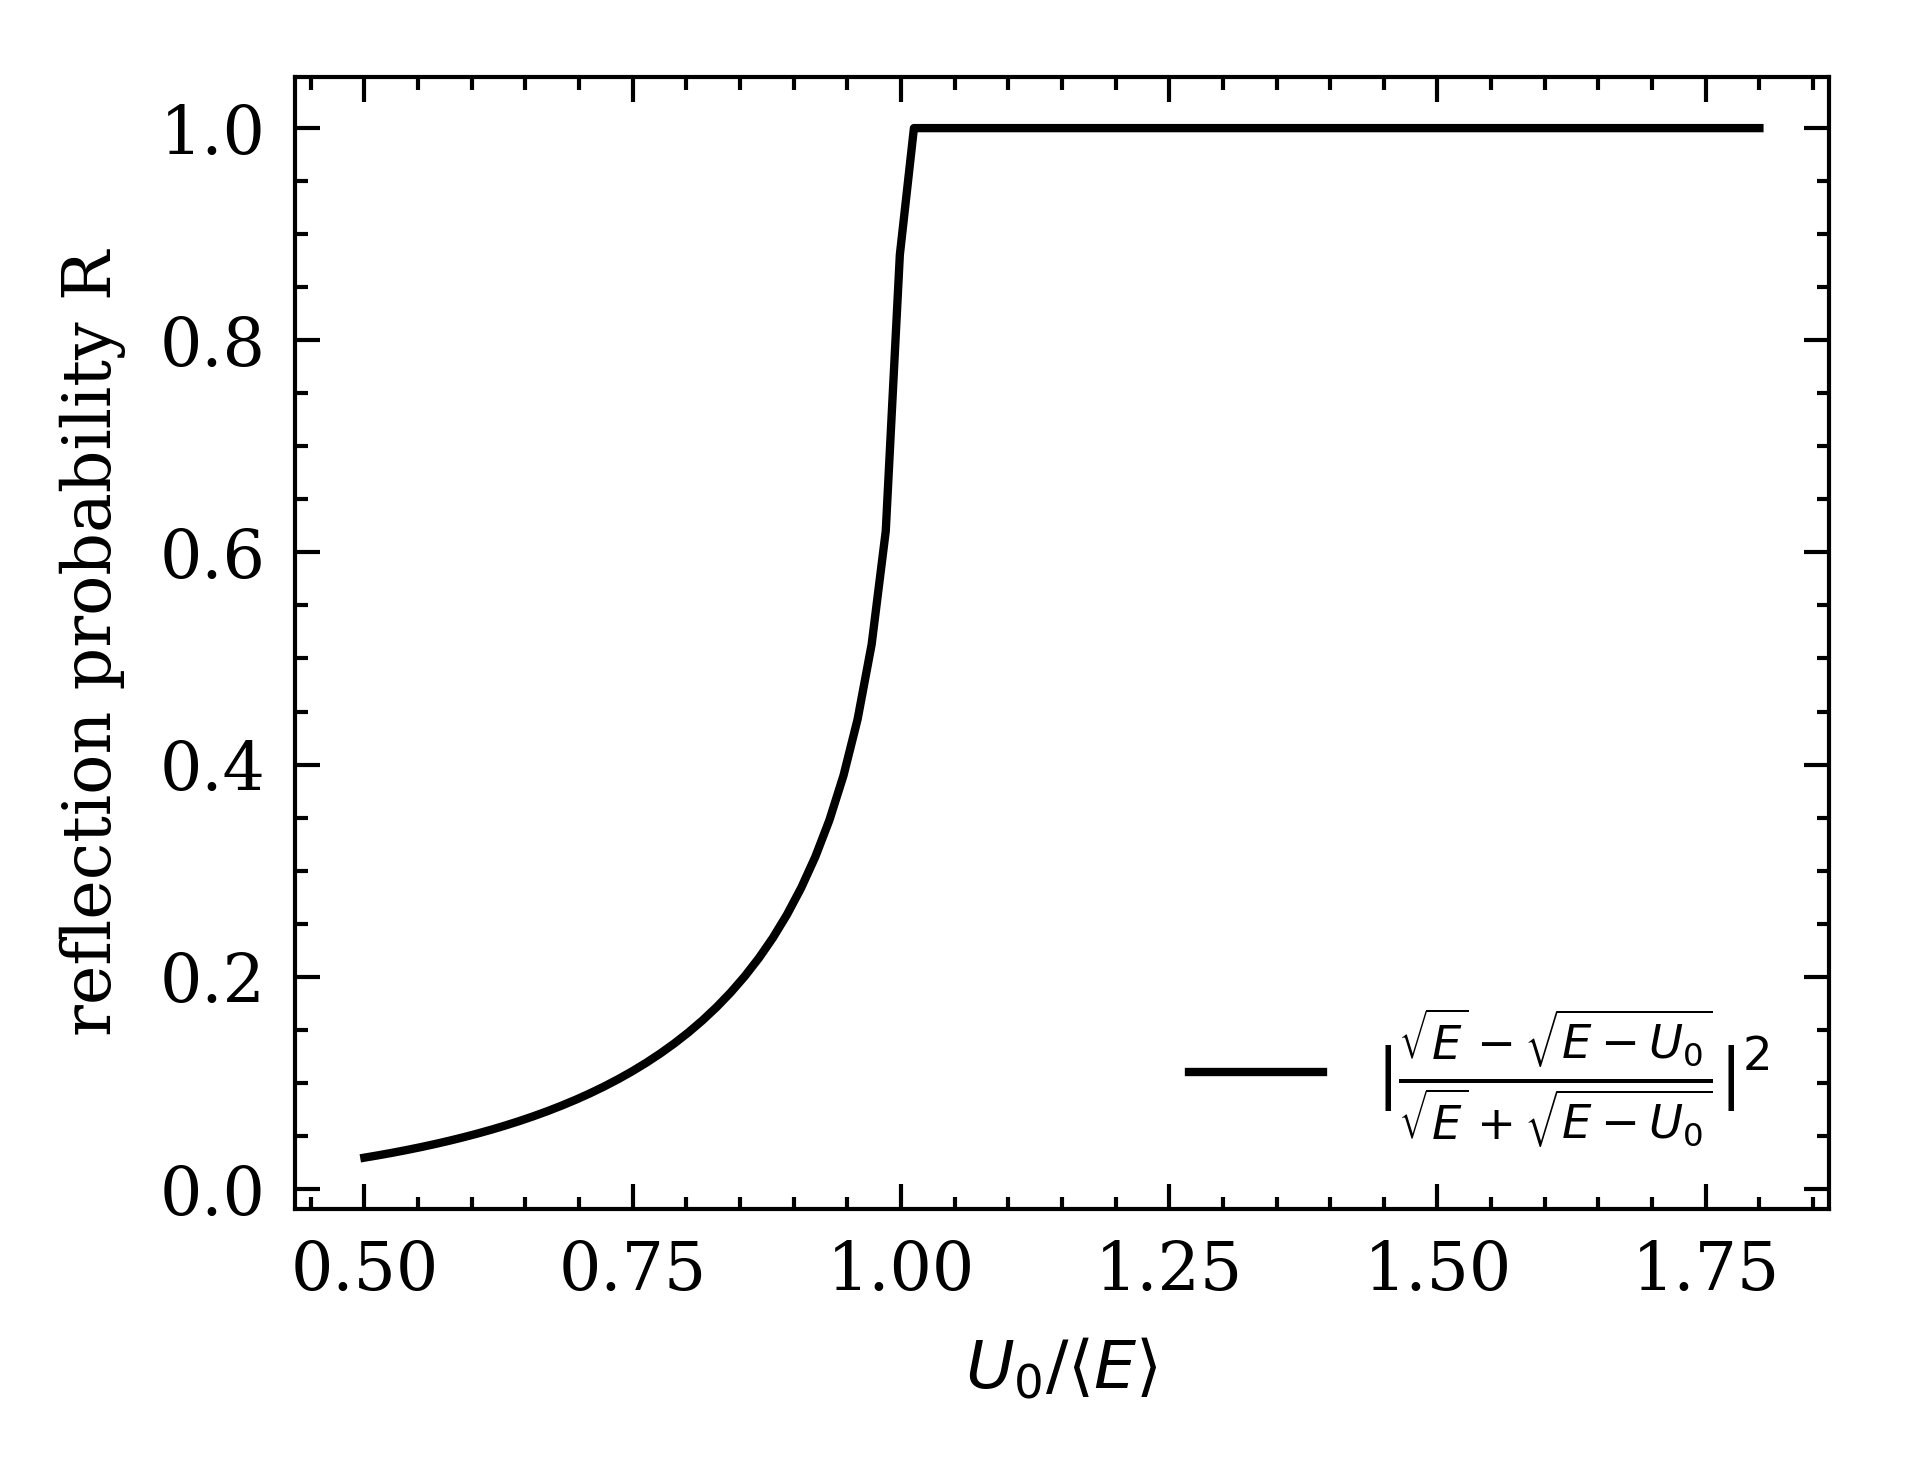

In [106]:
%matplotlib inline
def reflect_ana(ratio, E0=2.06):
    U = ratio * E0
    a = np.sqrt(E0)
    b = np.sqrt(E0 - U, dtype=np.complex)
    return np.abs((a - b) / (a + b))**2


with plt.style.context(["science", "ieee", "no-latex"]):
    x = np.linspace(0.5, 1.8, 100)
#     plt.plot(x, qt.avgE, 'ro', label="numerical")
    plt.plot(x, reflect_ana(x), 'k-', label=r"$\left| \frac{ \sqrt{E} - \sqrt{E - U_0} }{ \sqrt{E} + \sqrt{E - U_0} } \right|^2$")
    
    plt.xlabel(r'$U_0 / \langle E \rangle$')
    plt.ylabel('reflection probability R')
    
    plt.legend(loc='best')

In [104]:
qt.reflect_probability(rho_list[200])

0.9364010441944774

In [102]:
len(rho_list)

401

In [ ]:
rate